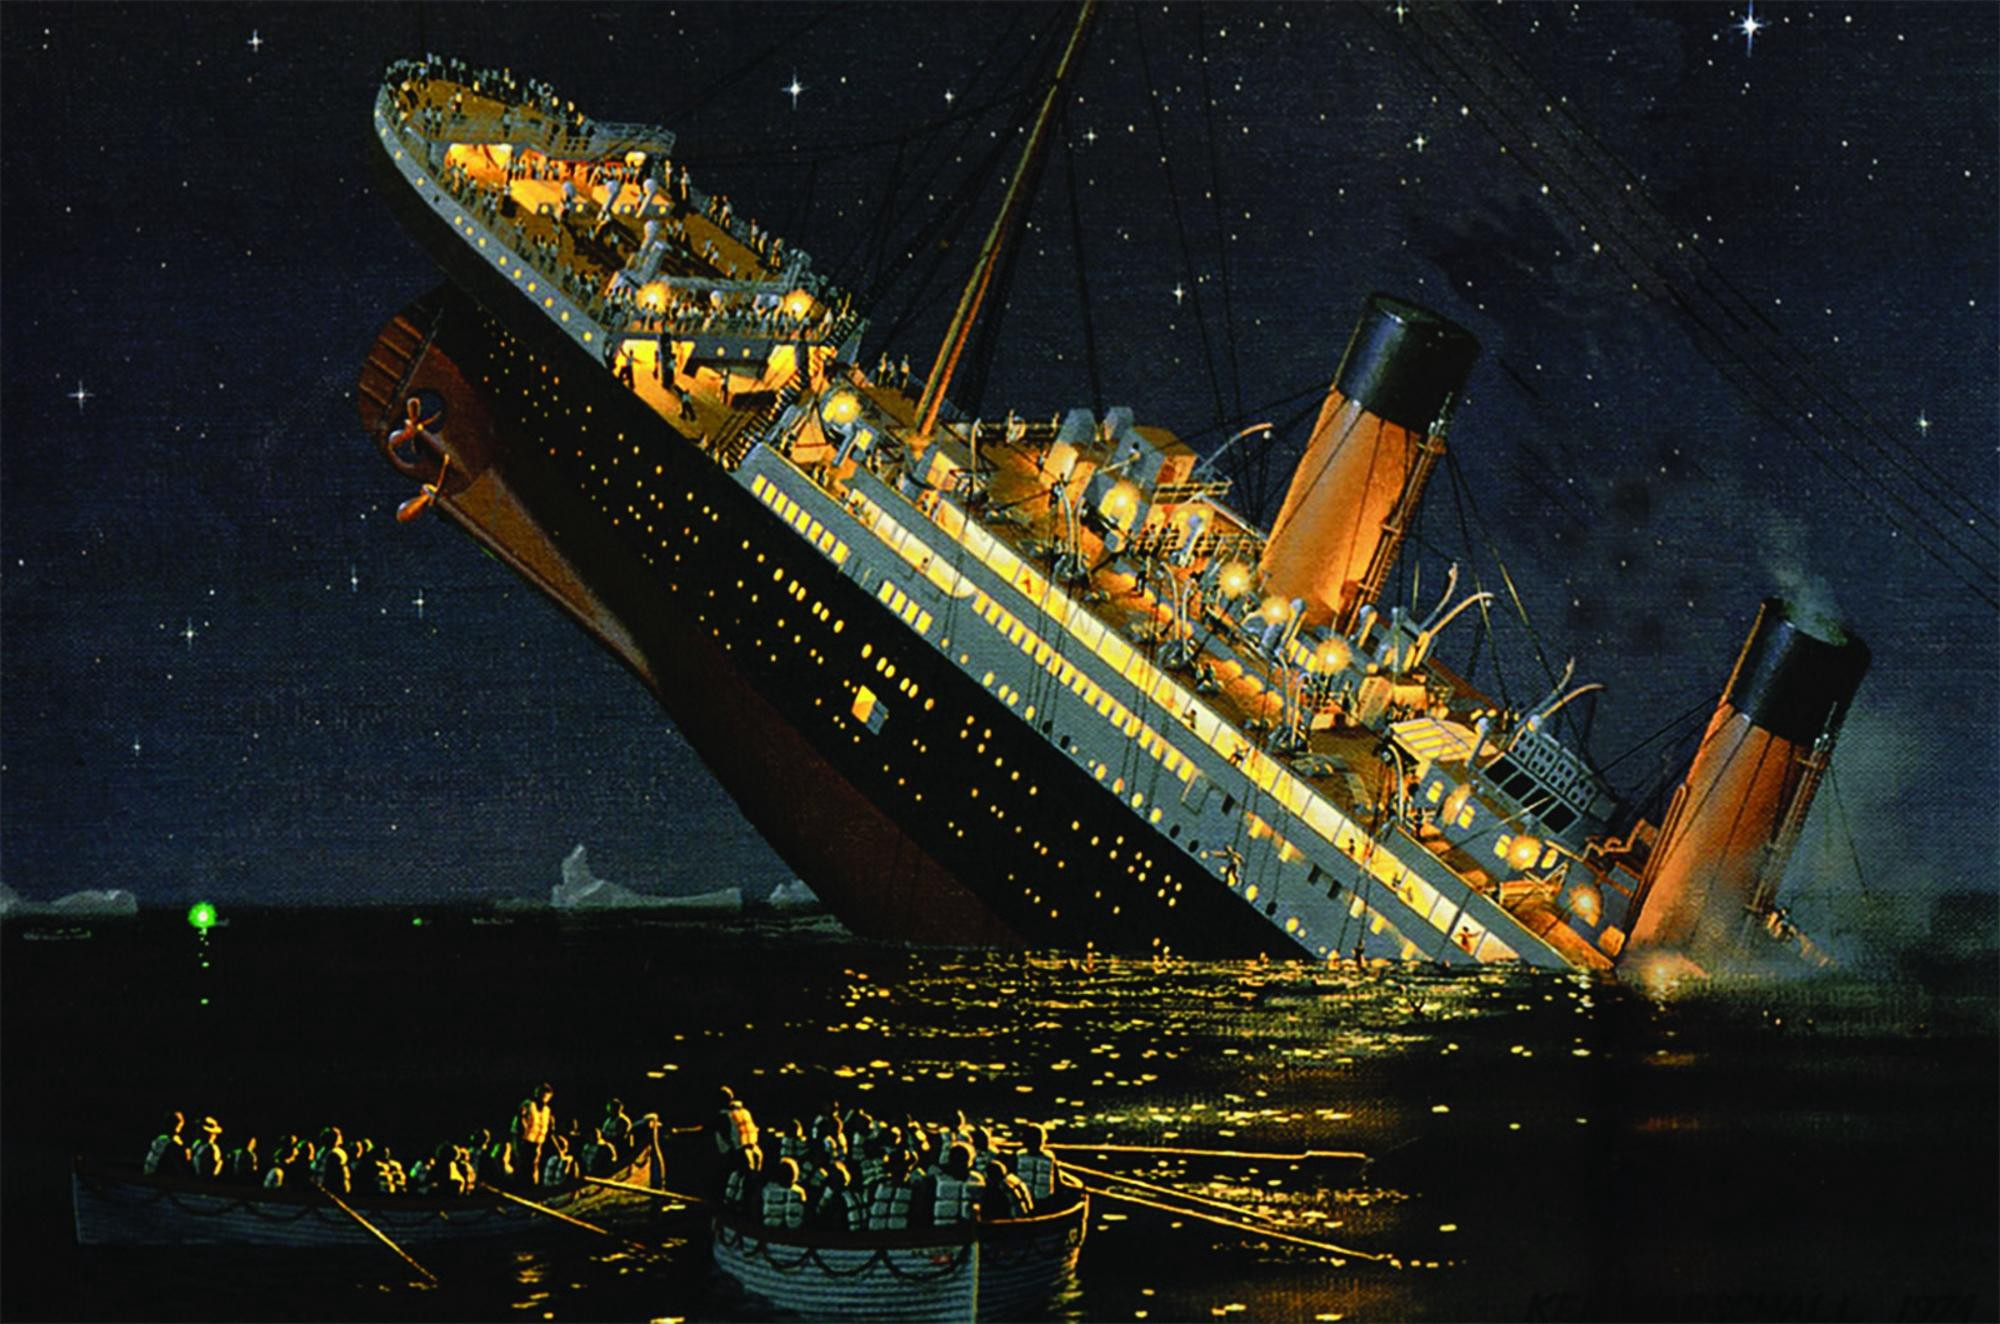

<center><h1 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Introduction</h1></center>

<p style = "color:black;font-weight:500;text-indent:20px;font-size:16px">The sinking of Titanic is one the most notorious shipwredcks in the history , In 1912, during her voyage, the titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.</p>

<p style = "color:black;font-weight:500;text-indent:20px;font-size:16px">First, we will simply examine our data.Later, we will prepare your data using functions, different from what we do normally this time.We will train the data we have prepared using the ANN model.We will examine them by drawing the acc and loss graphs of our model that we have trained.Finally, we will complete the project by performing the estimation process. </p>
    

<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Content :</h2>

<ul>
    <li style = "color:black;font-size:15px"> <a href = "#1" style = "color:black;font-weight:bold"> Load and Check Data </a> </li>
    <li style = "color:gray;font-size:15px"> <a href = "#2" style = "color:black;font-weight:bold"> Outlier Detection </a> </li>   
    <li style = "color:black;font-size:15px"> <a href = "#3" style = "color:black;font-weight:bold">  Preparing the Data </a> </li>
    <li style = "color:gray;font-size:15px"> <a href = "#4" style = "color:black;font-weight:bold">  Visualization </a> </li>
    <li style = "color:black;font-size:15px"> <a href = "#5" style = "color:black;font-weight:bold">  Prediction </a> </li>
    <li style = "color:gray;font-size:15px"> <a href = "#6" style = "color:black;font-weight:bold">  CONCLUSION </a> </li>
 </ul>

<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Import Libraries</h2>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from collections import Counter
from sklearn.model_selection import cross_val_score
import re

from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id ='1' ></a>
<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Load and Check Data </h2>

In [ ]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")

In [ ]:
#The Columns
train.columns

In [ ]:
train.head()

In [ ]:
train.describe()

In [ ]:
train.info()

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > Here we see some null values. We will not consider these in this project. If you want to see how we populate null values ​​in titanic data, you can check it out <a href = "https://www.kaggle.com/rafetcan/titanic-eda-visualization-prediction"> here </a>. </p> </li>
</ul>

In [ ]:
sns.countplot(train["Survived"], palette = ["black","gray"])
plt.show()
print(train.Survived.value_counts())

<a id ='2' ></a>
<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Outlier Detection </h2>

<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > We write a function to detect outliers in our data. </p> </li>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > We remove outliers in our data that we detected using the function. </p> </li>
</ul>

In [ ]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3st quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2) 
    
    return multiple_outliers

In [ ]:
train.loc[detect_outliers(train,["Age","SibSp","Parch","Fare"])]

In [ ]:
train = train.drop(detect_outliers(train,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop=True)

<a id ='3' ></a>
<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Preparing the Data </h2>

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > In this section, we will make our data suitable for our model. </p> </li>
</ul>

<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > Let's start with the preprocess function first. </p> </li>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > The cabin in our data consists of string values, we change it to int values. </p> </li>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > We do the same for gender. </p> </li>
     <li  style = "color:black" > <p style = "color:black;font-weight:bold" > We also convert embarked values to int values. </p> </li>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > Finally, if age, embarked and fare have null values, we fill them with medians. </p> </li>
</ul> 


In [ ]:
def preprocess(data):
    
    data.Cabin.fillna('0', inplace = True)
    data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
    data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
    data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
    data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
    data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
    data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
    data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
    data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
    
    data['Sex'].replace('female', 1, inplace =True)
    data['Sex'].replace('male', 2, inplace =True)
    
    data['Embarked'].replace('S', 1, inplace =True)
    data['Embarked'].replace('C', 2, inplace =True)
    data['Embarked'].replace('Q', 3, inplace =True)
    
    data['Age'].fillna(data['Age'].median(), inplace = True)
    data['Fare'].fillna(data['Fare'].median(), inplace = True)
    data['Embarked'].fillna(data['Embarked'].median(), inplace = True)
    
    return data

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > By using the group_titles function, we create a new property by editing the name property in our data. </p> </li>
</ul>

In [ ]:
def group_titles(data):
    
    data['Names'] = data['Name'].map(lambda x: len(re.split(' ', x)))
    data['Title'] = data['Name'].map(lambda x: re.search(', (.+?) ', x).group(1))
    data['Title'].replace('Master.', 0, inplace = True)
    data['Title'].replace('Mr.', 1, inplace = True)
    data['Title'].replace(['Ms.', 'Mlle.', 'Miss.'], 2, inplace = True)
    data['Title'].replace(['Mme.', 'Mrs.'], 3, inplace = True)
    data['Title'].replace(['Dona.', 'Lady.', 'the Countess.', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'the'], 4, inplace = True)
    
    
    

<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > We will send our data to our model and the function we set as input_dim. </p> </li>
</ul>

In [ ]:
def data_subset(data):
    
    features = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Names', 'Title', 'Age', 'Cabin', 'Fare', 'Embarked']
    lenght_features = len(features)
    subset = data[features].fillna(0)
    
    return subset, lenght_features

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > We write our function that we create and train our model. </p> </li>
</ul>

In [ ]:
def create_model(train_set_size, input_lenght, num_epochs, batch_size, x_test, y_test):
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = input_lenght))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(4, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    lr = .001
    adam0 = Adam(lr = lr)
    
    model.compile(loss = "binary_crossentropy", optimizer = adam0, metrics= ['accuracy'])
    
    hist = model.fit(X_train[:train_set_size], Y_train[:train_set_size], validation_data=(x_test,y_test), epochs=num_epochs, batch_size=batch_size, verbose=-1)
    
    return model, hist
    


<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > We visualize the acc and loss values ​​of our model that we have created. </p> </li>
</ul>

In [ ]:
def plots(history):
    plt.plot(history.history["loss"],label = "Train Loss")
    plt.plot(history.history["val_loss"],label = "Validation Loss")
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(history.history["accuracy"],label = "Train Accuracy")
    plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
    plt.legend()
    plt.show()

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > we write a function to test the model we have created. </p> </li>
</ul>

In [ ]:
def test(batch_size):
        
    test = pd.read_csv('/kaggle/input/titanic/test.csv')
    test_ids = test['PassengerId']

    test = preprocess(test)
    group_titles(test)
    testdata, _ = data_subset(test)

    X_test = np.array(testdata).astype(float)

    output = model.predict(X_test, batch_size=batch_size, verbose=0)
    output = output.reshape((418,))

    test_data = pd.DataFrame()
    test_data["PassengerId"] = test_ids
    test_data["Survived"] = output
    
    return test_data

<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > yes, it is time to use these functions we have created. </p> </li>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > We send our train data to the functions we have created. </p> </li>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > We determine our num_epochs and batch_size values. </p> </li>
</ul>

In [ ]:
preprocess(train)
group_titles(train)


num_epochs = 100
batch_size = 16

traindata, lengh_features = data_subset(train)

Y_train = np.array(train['Survived']).astype(int)
X_train = np.array(traindata).astype(float)

train_set_size = int(.85 * len(X_train))

X_validation = X_train[train_set_size:]
Y_validation = Y_train[train_set_size:]

model, history_model = create_model(train_set_size, lengh_features, num_epochs, batch_size, X_validation, Y_validation)


loss_and_metrics = model.evaluate(X_validation, Y_validation, batch_size=batch_size)
print ("loss_and_metrics")

<a id ='4' ></a>
<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Visualization</h2>

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > We visualize our loss and acc values by sending them to the function we created above. </p> </li>
</ul>

In [ ]:
plots(history_model)

<a id ='5' ></a>
<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">Prediction</h2>

<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > Yes, we make predictions using the model we have created so far. While performing this process, we will make use of the function we created earlier. </p> </li>
</ul>

In [ ]:
predict_data = test(batch_size)
predict_data

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > As you can see, our estimation results came. but now decimal values. We convert them to values ​​0 and 1 by setting a limit value. We set this limit value as 0.6 as you can see below. </p> </li>
</ul>

In [ ]:
new_pred = []
for i in predict_data["Survived"]:
    
    if i >=0.6:
        new_pred.append(1)
    else:
        new_pred.append(0)

In [ ]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
test_ids = test['PassengerId']

In [ ]:
predict_survived = pd.DataFrame()
predict_survived['PassengerId'] = test_ids
predict_survived['Survived'] = new_pred
predict_survived

<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > yes, we made our decimal values 0 or 1.</p> </li>
</ul>

In [ ]:
plt.figure()
sns.countplot(new_pred)
plt.show()

<ul>
    <li  style = "color:black" > <p style = "color:black;font-weight:bold" > Finally, we took a look at the predictions we made by visualizing them.</p> </li>
</ul>

<a id ='6' ></a>
<h2 style = "background-image: linear-gradient(200deg, gray, black);color:white;border:0">CONCLUSION</h2>

<ul>
    <li  style = "color:gray" > <p style = "color:black;font-weight:bold" > First of all, thank you very much for looking up here. I am waiting for your suggestions and good wishes. </p> </li>
    <li>⚓ Titanic - EDA - Visualization - Prediction ⚓ : <a href = 'https://www.kaggle.com/rafetcan/titanic-eda-visualization-prediction'> https://www.kaggle.com/rafetcan/titanic-eda-visualization-prediction </a> </li>
</ul>